<a href="https://colab.research.google.com/github/andylynchul/CE6003/blob/main/Week%201/CE6003_20208189_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etivity Assignment 1: Ships in Satellite Imagery
In this assignment we will build & train an object detector to solve the problem of idenifying ships in satellite imagery. 

![link text](https://github.com/tonyscan6003/CE6003/blob/master/images/sat_img1.JPG?raw=true)

This assignment demonstrates that classical image processing techniques may be used in preference to deep learning for certain applications. Particularly those that are limited in computational power or require fast execution. 



This lab uses a [kaggle dataset](https://www.kaggle.com/rhammell/ships-in-satellite-imagery). Please read the [PDF](https://github.com/tonyscan6003/CE6003/blob/master/images/CE6003_kaggle_data_instructions.pdf) detailing how to setup your PC so that you can use a kaggle dataset within Colab.  The dataset contains image patches of ships as well as background images of sea and coastline. 

![Ships in Satellite imagery](https://i.imgur.com/tLsSoTz.png)

This assigment contains all the code necessary to read the downloaded kaggle files and create image and label arrays with test and train splits.




# Dowload Kaggle Dataset.


In [1]:

! pip install -q kaggle==1.5.6
from google.colab import files
files.upload()

     |████████████████████████████████| 58 kB 2.9 MB/s 


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andylynchul","key":"9f5386f46f9cd1d41e80b534b26deb41"}'}

In [2]:
# Use this only if have problems with stale .json file
#!rm kaggle.json
#!rm ~/.kaggle/kaggle.*

In [3]:
#Choose the kaggle.json file that you downloaded
! mkdir ~/.kaggle
#Make directory named kaggle and copy kaggle.json file there.
! cp kaggle.json ~/.kaggle/
#Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

# Load dataset
! kaggle datasets download rhammell/ships-in-satellite-imagery

!unzip ships-in-satellite-imagery.zip > /dev/null

 98% 181M/185M [00:02<00:00, 133MB/s]
100% 185M/185M [00:02<00:00, 94.2MB/s]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Library Import & Functions
 Import packages, helper functions to read from URL and import images.

In [6]:

from skimage import feature
from skimage import exposure
from sklearn import svm
from sklearn.model_selection import train_test_split
import numpy as np
import glob
import urllib.request
import cv2
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression

def url_to_image(url):
  	resp = urllib.request.urlopen(url)
  	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
  	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
  	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB here..
  	return temp_image

def read_image(image_url):
    image = url_to_image(image_url)
    x,y,z = np.shape(image)
    # Image is scaled to reduce computation time
    image = cv2.resize(image, dsize=(int(y/sf), int(x/sf)), interpolation=cv2.INTER_CUBIC)
    return image

In [7]:
# Read downloaded file list: Files are comprised of positive (ship) and negaitive (Not ship) examples

pos_img_list = glob.glob('shipsnet/shipsnet/1_*.png')
neg_img_list = glob.glob('shipsnet/shipsnet/0_*.png')

# this repository of imagery was generated by tracking detections but saving the FP's and feeding them back in to train the model
print("Load Manually Extracetd Negatives")  
files = glob.glob(directory + "/*")
for f in files:
  neg_img_list.append(f)

# Sanity check of the number of loaded training images
print(np.shape(neg_img_list)[0])

Load Manually Extracetd Negatives
3444


# Read Data 
Read data from unzipped downloaded files and create the Training and Test sets. (Note that these are training and test sets of image patches that can be used to train an image classifier)

In [8]:
# Set variables
n = 80 # number of x,y pixels in this image.
neg_pts = np.shape(neg_img_list)[0]
pos_pts = np.shape(pos_img_list)[0]
n_pts = neg_pts + pos_pts # number of points to use (are 4000 in dataset, 1000 positive 3000 negative)

In [9]:

def read_images(img_list):
   train_pos = np.empty([1,n*n])
   # Function to read images from file list 
   for i in range(len(img_list)): 
      img_path = img_list[i]
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      #  store image as row in array
      train_pos = (np.concatenate((train_pos,np.reshape(img, (1, n*n)))) if i > 0 else  np.reshape(img, (1, n*n)))
   return train_pos 

In [10]:
# Read positive and negative shp images into arrays 
pos_img = read_images(pos_img_list)
neg_img = read_images(neg_img_list)


In [11]:
# create corresponding arrays of labels
y_pos_labels = np.ones(len(pos_img_list))
y_neg_labels = np.zeros(len(neg_img_list))

In [12]:
# Combine positive and negative images into one dataset. 
dataset_img = np.concatenate((pos_img[0:,:],neg_img[0:,:]))
dataset_labels = np.append(y_pos_labels,y_neg_labels)

In [13]:
# Training examples
n_train = int(0.7*n_pts)

# Divide into training and test sets with labels
X_train, X_test, y_train, y_test = train_test_split(dataset_img, dataset_labels, train_size=n_train,
                                                    random_state=0,
                                                    stratify=dataset_labels)

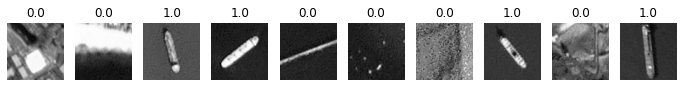

In [14]:
# Plot some examples from the training data
n_plots = 10 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(12,20))
for i in range(0,n_plots,1):
   axarr[i].imshow(np.reshape(X_train[i,0:n*n], (n, n)) ,'gray')
   axarr[i].axis('off')
   axarr[i].title.set_text(y_train[i])

#Build and Train an Image Classifier
The approach taken to the Image Classifer was to represent the images by extracting the HOG features, train an SVM model based on this representation and apply a sliding window implementation to images to attempt to identify targeted objects (Ships).




Inspiration Source : https://medium.com/swlh/histogram-of-oriented-gradients-hog-for-multiclass-image-classification-and-image-recommendation-cf0ea2caaae8

Steps to feature engineer an image:
1. Resize : Done // All images are 80x80 (4000)
2. Normalize  : HOG is Scaled before training model
3. Filter : Gaussian Blur applied to image before HOG features are extracted

In [15]:
# extract an image to HOG features from image
# visualise is set to False to speed up processing
def get_hog(dataset,bX,bY):
  hog_features = []
  for i in (range(0,len(dataset),1)):
    image = np.reshape(dataset[i,0:n*n], (n, n))
    blur = cv2.GaussianBlur(image,(5,5),0)
    fd = hog(blur, orientations=10, pixels_per_cell=(bX, bY), cells_per_block=(int(bX/4), int(bY/4)), block_norm = 'L2', visualize=False)
    hog_features.append(fd)
  
  hog_features = np.array(hog_features)
  
  return hog_features

## GridCV to validate model parameter selection

In [33]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'decision_function_shape': ['ovo']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, cv=3)
 
# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] decision_function_shape=ovo .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......... decision_function_shape=ovo, score=0.957, total=  23.3s
[CV] decision_function_shape=ovo .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.3s remaining:    0.0s


[CV] ......... decision_function_shape=ovo, score=0.969, total=  23.3s
[CV] decision_function_shape=ovo .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.6s remaining:    0.0s


[CV] ......... decision_function_shape=ovo, score=0.947, total=  23.0s
[CV] decision_function_shape=ovo .....................................
[CV] ......... decision_function_shape=ovo, score=0.958, total=  23.0s
[CV] decision_function_shape=ovo .....................................
[CV] ......... decision_function_shape=ovo, score=0.952, total=  23.1s
[CV] decision_function_shape=ovr .....................................
[CV] ......... decision_function_shape=ovr, score=0.957, total=  23.2s
[CV] decision_function_shape=ovr .....................................
[CV] ......... decision_function_shape=ovr, score=0.969, total=  23.4s
[CV] decision_function_shape=ovr .....................................
[CV] ......... decision_function_shape=ovr, score=0.947, total=  22.9s
[CV] decision_function_shape=ovr .....................................
[CV] ......... decision_function_shape=ovr, score=0.958, total=  22.9s
[CV] decision_function_shape=ovr .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.9min finished


{'decision_function_shape': 'ovo'}
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [104]:
# Testing new feature in article above
import tqdm
from skimage.feature import hog
from google.colab.patches import cv2_imshow
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

test_accuracy = []
hog_w = 16

# with scaling
steps = [('scaler', StandardScaler()), ('SVM', svm.SVC(decision_function_shape='ovo'))] 



# without scaling
#steps = [('SVM', svm.SVC(decision_function_shape='ovo'))] 

X_Train_Hog = get_hog(X_train,hog_w,hog_w)
X_test_Hog = get_hog(X_test,hog_w,hog_w)

classifier = Pipeline(steps) 

classifier.fit(X_Train_Hog, y_train)

y_pred = classifier.predict(X_test_Hog)

test_accuracy = classifier.score(X_test_Hog, y_test)

print(test_accuracy)

0.9910044977511244


In [105]:
steps_no_scale = [('SVM', svm.SVC(decision_function_shape='ovo'))] 

classifier_no_scale = Pipeline(steps_no_scale) 

classifier_no_scale.fit(X_Train_Hog, y_train)

y_pred_no_scale = classifier_no_scale.predict(X_test_Hog)

test_accuracy = classifier_no_scale.score(X_test_Hog, y_test)

print(test_accuracy)

0.9902548725637181


Test performance of your classifier using the test dataset and obtain a [classification report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report).

You can plot some examples from the test set using the function in the cell below.  

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1034
         1.0       0.98      0.98      0.98       300

    accuracy                           0.99      1334
   macro avg       0.99      0.99      0.99      1334
weighted avg       0.99      0.99      0.99      1334



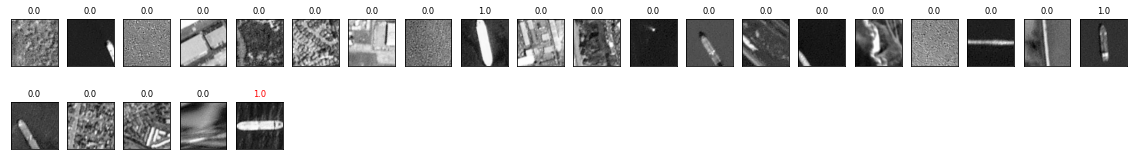

In [95]:
print(classification_report(y_test, y_pred))

def plot_examples(y_pred,y_test):
   n_plots = 25 # number of plots
   fig = plt.figure(figsize=(20, 15))
   for i in range(n_plots):
      ax = fig.add_subplot(10, 20, i + 1, xticks=[], yticks=[])
      ax.imshow(np.reshape(X_test[i,0:n*n], (n, n)) ,'gray')
      color = ('black' if y_pred[i] == y_test[i] else 'red')
      ax.set_title(y_test[i],
                 fontsize='small', color=color)
      
plot_examples(y_pred,y_test) 

# 2. Aplication of Classifier for Object Detector 






In [106]:
def find_ships(img_path, model, store=False):
  #read the color image
  col_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  # convert to greyscale image
  gray_img = cv2.cvtColor(col_img, cv2.COLOR_BGR2GRAY)

  #object detection function output
  found_boxes = []

  # grab the dimensions of the image to process 
  h, w = gray_img.shape

  # nested for loop provide the sliding window functionality the step size : n/8 specifies the granularity of the slider.
  for idx, y in enumerate(range(0, h, int(n/8))):
    for idy, x in enumerate(range(0, w, int(n/8))):
      # y_lim ,x_lim set the width and height of the block
      y_lim = (y + n) 
      x_lim = (x + n)

      # test to see of the window extremities have extended beyind that of the image
      if y_lim < h and x_lim < w:
        # extract the window image
        sample_img = gray_img[y:y_lim,x:x_lim]

        # secondary test to validate a full sample has been extracted
        if (sample_img.shape[0] == n and sample_img.shape[1] == n ): 
          #convert the nxn matrix in to a 1xn matrix to faciliate HOG extraction
          sample = np.reshape(sample_img, (1, n*n))
          # extract hog features
          sample_Hog = get_hog(sample,hog_w,hog_w)
          # apply the classifer (using the Pipeline applied the scaling followed by SVM)
          isShip = model.predict(sample_Hog)
          # if a ship is detected
          if isShip:
            # update the found_boxed list - this is the co-ordinates of the box that will be applied to the image to visualise the detection
            found_boxes.append([x,y,x_lim,y_lim])
            
            # if the store parameter is set to True the image will be exporetd to the image repo used to retrain the models
            if store:
              cv2.imwrite(directory + "/0_Extracted_" + str(idx) + "_" + str(idy) + ".png", sample_img) 

  # Load and Display Secene to perform Object Detection on
  gray_img_final = col_img.copy()

  #Bounding box parameters
  lineColor = (0, 255, 0)
  lineThickness = 4

  # convert the found_boxes (list) to an array
  found_boxes_arr = np.array(found_boxes)

  # run non-max suppression on these based on an overlay of 20%
  nmsBoundingBoxes = non_max_suppression(found_boxes_arr, probs=None, overlapThresh=0.2)

  # draw the final bounding boxes
  for (xA, yA, xB, yB) in nmsBoundingBoxes:
      cv2.rectangle(gray_img_final, (xA, yA), (xB, yB), lineColor, lineThickness)

  # Plot figures
  plt.figure(figsize=(14, 10), dpi=80)
  plt.imshow(gray_img_final, aspect='auto') 
  plt.show()

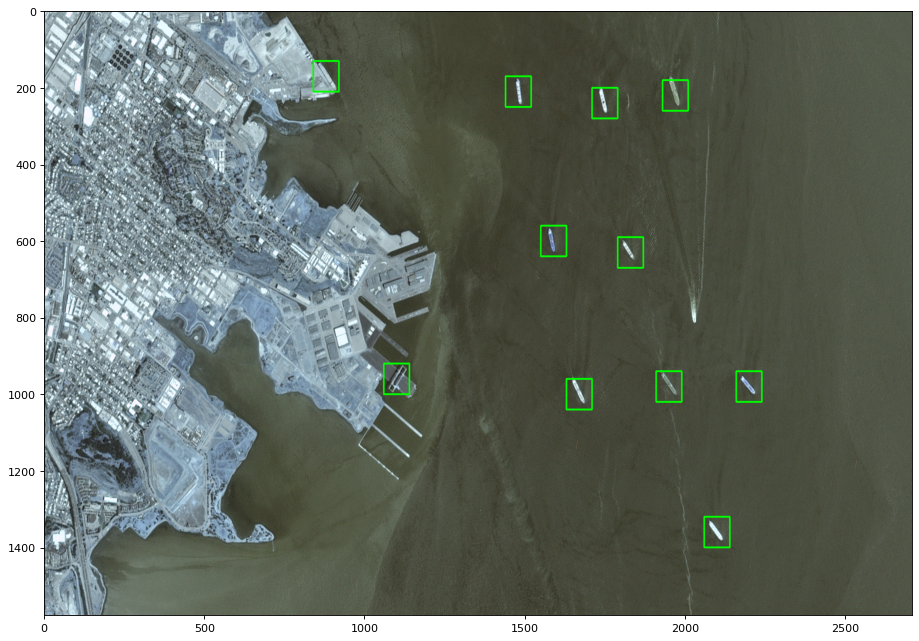

In [107]:
# apply the object detector to image
find_ships('scenes/scenes/sfbay_3.png', classifier, store=False)

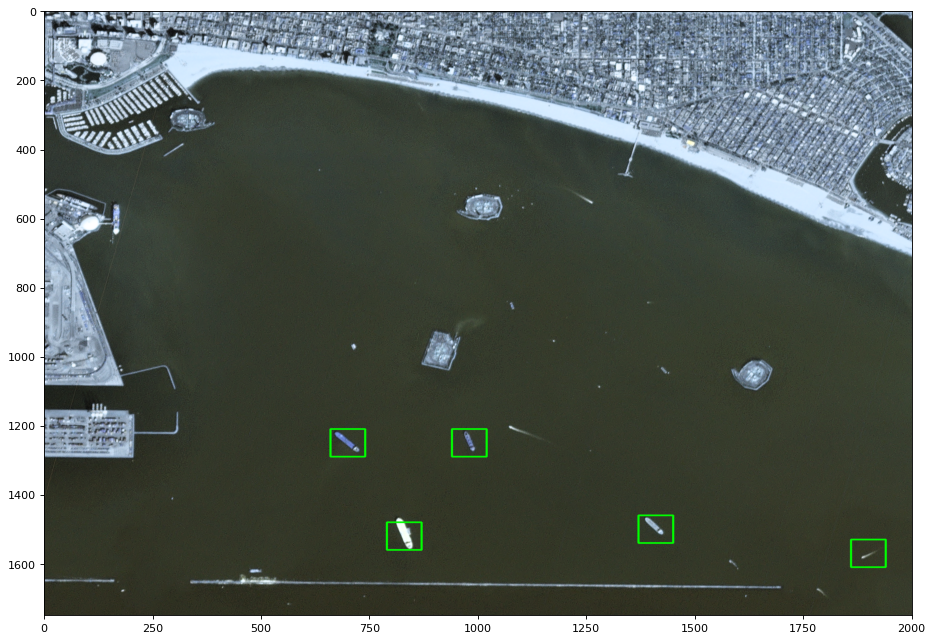

In [98]:
# apply the object detector to image
find_ships('scenes/scenes/lb_1.png', classifier, store=False)

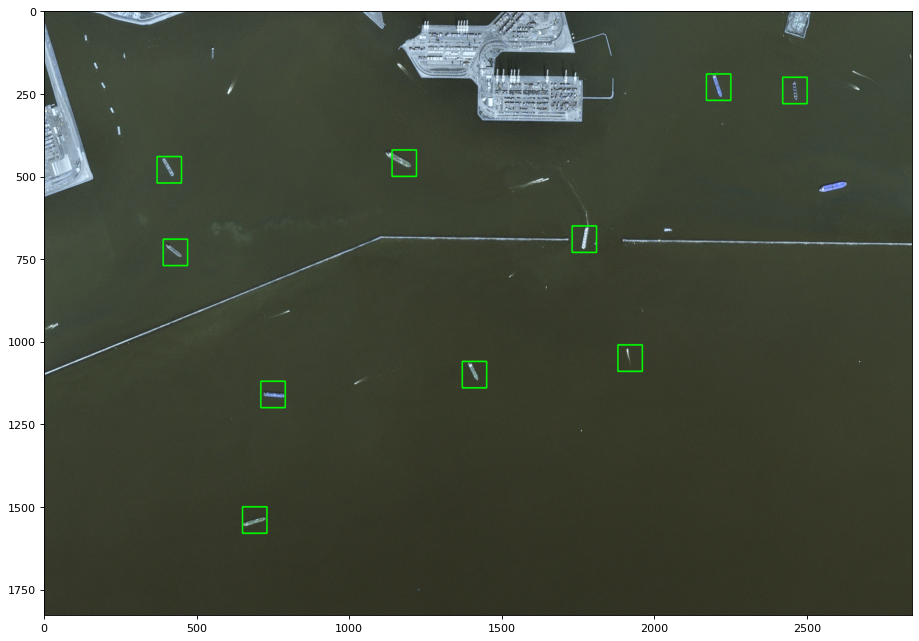

In [99]:
# apply the object detector to image
find_ships('scenes/scenes/lb_2.png', classifier, store=False)

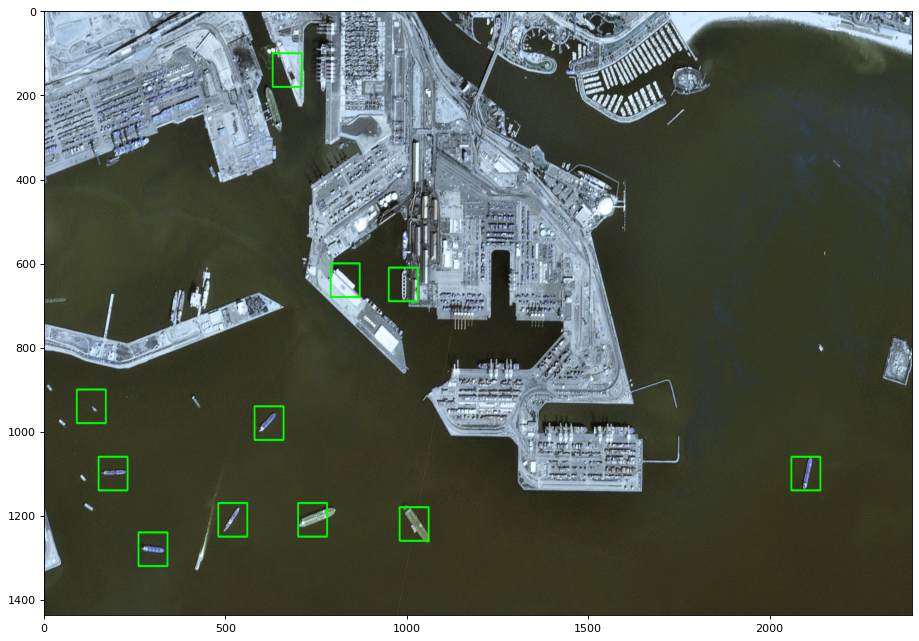

In [100]:
# apply the object detector to image
find_ships('scenes/scenes/lb_3.png', classifier, store=False)

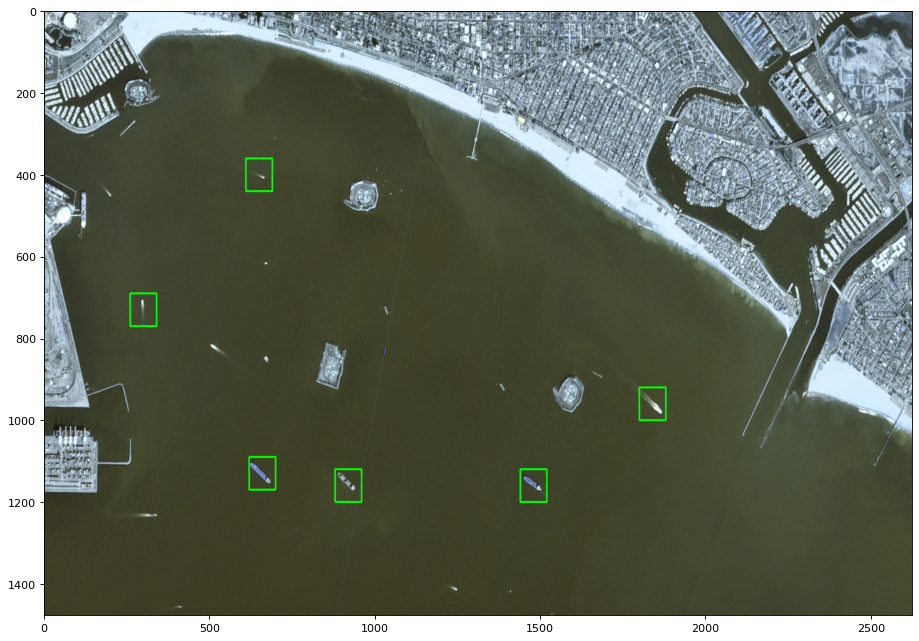

In [101]:
# apply the object detector to image
find_ships('scenes/scenes/lb_4.png', classifier, store=False)

# Representation of Alternative Model
This block was used to visualise the effect of tuning certain parameters on the model. In this case the Scaling stage was left out of the Pipeline to see the effect.

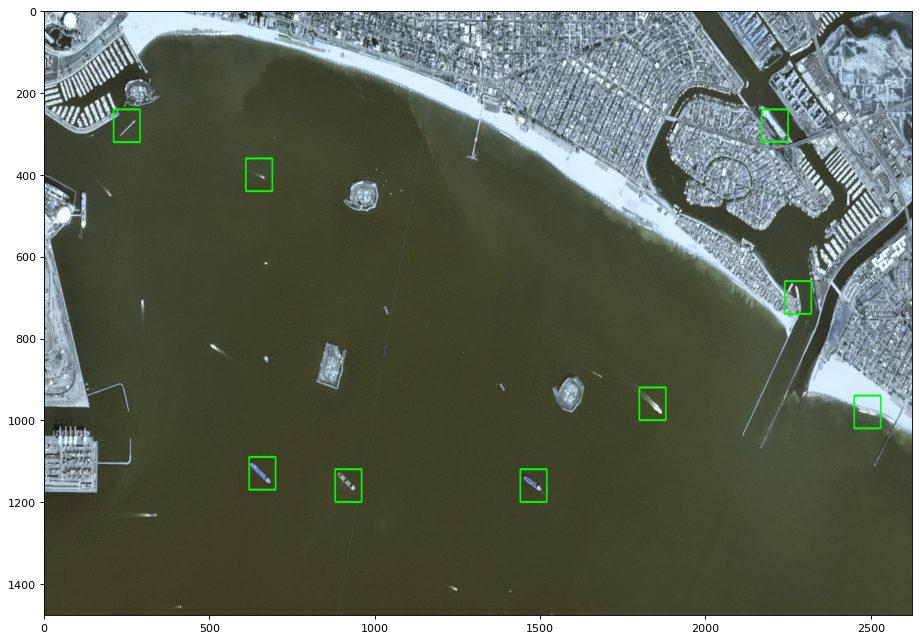

In [109]:
# apply the object detector to image
find_ships('scenes/scenes/lb_4.png', classifier_no_scale, store=False)

# Conclusion & Reflection

The exercise involved the design and implementation of an Object Detector to analyse an aerial photograph and to identify ships in that image. The training dataset was provided that consisted of a set of ship images with a set of corresponding classifications. The set was made up of 1000 positive samples and 3000 negative images. The problem was defined as a binary classification problem.

The high-level analysis required specification of:
1. Representation of images in an appropriate format
2. Model to train & perform the classification
3. Method of analysing an image and applying the object detection routine

The first item required was representation. The Histogram of Orientation Gradients (HOG) approach was used to represent the images in a machine-readable format. The OpenCV library was used to apply the processing. Practically, each of the images was read into the application and each was converted to a single row 1xn matrix for processing. The HOG features were then extracted and saved for processing. Speed of processing was an important factor in the learning of this exercise. One major improvement found was to disable the visualise function of the HOG extractor so it wasn’t forced to render an image. The initial block size of the HOG extractor was set to 8x8 and once good accuracy was achieved loosening the window size to 16x16 was investigated. This resulted in maintained accuracy and considerable improvements in processing time. processing an image at the outset took in the order of 10-12 mins and tuning the block size and disabling the visualise feature reduced the processing time to ~1.5 mins.

The second aspect of the problem was solved by employing a simple SVM classifier to train on the supplied training data. Cross-validation was used to identify the optimal configuration to use and it was decided to use the SVC variant with RBF kernel and the default C value. An accuracy score of 99.1% was achieved during the training phase of the exercise. This was satisfactory to proceed with.

The image processing aspect of the solution involved the implementation of a sliding window feature. The implementation involved defining the width and height of the window and then iterating over the image. At each iteration, the sub-images (that defined by the window) was extracted and pushed through the classification pipeline to get a read whether a ship was detected or not. On detection of a ship, the window coordinates were stored and subsequently overlayed on the image to visualise the detection. 

In the early implementation, several false positives were observed so it was investigated if creating manual feedback of FP's would improve the accuracy. It was noticed sections of shoreline, pipes, piers were being picked up as ships. The classification routine was run on three of the sample images - FP’s were stored in GDrive and the model was then retrained with these negative samples. An obvious improvement was seen on the training images so to test the generality of the model three further images were tested and the results visually were very positive.

In conclusion, the exposure to the HOG feature extraction was very insightful in how entities can be transformed and represented to allow for ML processing. It was very satisfying to see the ML algorithm in action. It was also very useful to see how tuning certain parameters (even slightly) can affect the accuracy of the output. An example of this was to skip the Scaling step in the Pipeline and apply the model accordingly. A slight drop in model accuracy score was found and it resulted in 4 additional False Positives.